## Classify the flowers shown in the flower dataset

* The flowers are in color and you'll have to work with that. You can't turn them to greyscale etc.
* Data augmentation is allowed here due to popular complaint, but the problem can be completed without it




In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import torch
from torchvision import datasets,models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!pip install torchsummary 
from torchsummary import summary

/home/anirudh/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Loading the Training and Testing Data using Data Loader with Data Augmentation

In [2]:
# Loading the Training and Testing Data
trainImages = np.load('./Flowers/flower_imgs.npy')
trainLabels = np.load('./Flowers/flower_labels.npy')
# Splitting the Data into Training and Test Data
X_train, X_test,Y_train,Y_test = train_test_split(trainImages,trainLabels, test_size=0.15, shuffle = True)

# Finding the mean and the Variance
img_mean = np.mean(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
img_std = np.std(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
print("mean: {}, std: {}".format(img_mean, img_std))


mean: [0.43430043 0.43250865 0.35484957], std: [0.28290703 0.26667351 0.25423616]


In [3]:
class FlowerLoader(torch.utils.data.Dataset):
    def __init__(self, x_arr, y_arr, transform=None):
        self.x_arr = x_arr
        self.y_arr = y_arr
        self.transform = transform

    def __len__(self):
        return self.x_arr.shape[0]

    def __getitem__(self, index):
        img = self.x_arr[index]
        label = self.y_arr[index]
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [4]:
## Normalizing the Data
normalize = transforms.Normalize(mean=list(img_mean),std=list(img_std))
batch_size =128

train_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_train, Y_train, transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True)
# remove augmentation transforms in test loader
test_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_test, Y_test, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False)

In [5]:
# sample for iterating over loader
# for img, label in train_loader:
#     img, label = img.to(device), label.to(device)

# Showing the Input Data 

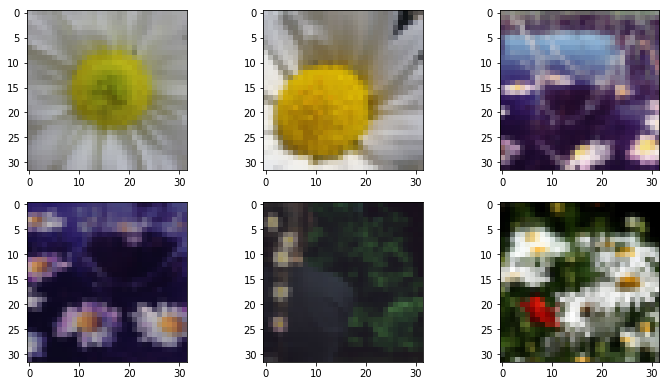

In [6]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(trainImages[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [8]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 5]             425
Total params: 61,581
Trainable params: 61,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [9]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 3, 5, 5])


##  Define a Loss function and optimizer

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

## Training and Testing

In [30]:
def train(model, train_loader, optimizer, epoch,device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(target.dtype,output.dtype)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        lo.append(loss.item())
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
#             print(test_loss)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_accu.append(100. * correct / len(test_loader.dataset))
    test_loss /= len(test_loader.dataset)
    val_loss.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [31]:
 test(net, test_loader,device)


Test set: Average loss: -2.5375, Accuracy: 432/649 (67%)



# Training the Model

In [12]:
epochs = 200
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/3674 (0%)]	Loss: 1.609119
Train Epoch: 1 [1280/3674 (34%)]	Loss: 1.613093
Train Epoch: 1 [2560/3674 (69%)]	Loss: 1.614923

Test set: Average loss: 0.0247, Accuracy: 135/649 (21%)

Train Epoch: 2 [0/3674 (0%)]	Loss: 1.616801
Train Epoch: 2 [1280/3674 (34%)]	Loss: 1.615334
Train Epoch: 2 [2560/3674 (69%)]	Loss: 1.602285

Test set: Average loss: 0.0221, Accuracy: 135/649 (21%)

Train Epoch: 3 [0/3674 (0%)]	Loss: 1.597892
Train Epoch: 3 [1280/3674 (34%)]	Loss: 1.605343
Train Epoch: 3 [2560/3674 (69%)]	Loss: 1.614925

Test set: Average loss: 0.0193, Accuracy: 135/649 (21%)

Train Epoch: 4 [0/3674 (0%)]	Loss: 1.601836
Train Epoch: 4 [1280/3674 (34%)]	Loss: 1.610008
Train Epoch: 4 [2560/3674 (69%)]	Loss: 1.596627

Test set: Average loss: 0.0163, Accuracy: 135/649 (21%)

Train Epoch: 5 [0/3674 (0%)]	Loss: 1.605257
Train Epoch: 5 [1280/3674 (34%)]	Loss: 1.593565
Train Epoch: 5 [2560/3674 (69%)]	Loss: 1.603367

Test set: Average loss: 0.0131, Accuracy: 135/649 (21%)

Train Epoc

Train Epoch: 42 [1280/3674 (34%)]	Loss: 1.313662
Train Epoch: 42 [2560/3674 (69%)]	Loss: 1.214375

Test set: Average loss: -1.4291, Accuracy: 333/649 (51%)

Train Epoch: 43 [0/3674 (0%)]	Loss: 1.307664
Train Epoch: 43 [1280/3674 (34%)]	Loss: 1.094912
Train Epoch: 43 [2560/3674 (69%)]	Loss: 1.163454

Test set: Average loss: -1.4282, Accuracy: 326/649 (50%)

Train Epoch: 44 [0/3674 (0%)]	Loss: 1.355286
Train Epoch: 44 [1280/3674 (34%)]	Loss: 1.275663
Train Epoch: 44 [2560/3674 (69%)]	Loss: 1.231079

Test set: Average loss: -1.4325, Accuracy: 335/649 (52%)

Train Epoch: 45 [0/3674 (0%)]	Loss: 1.181076
Train Epoch: 45 [1280/3674 (34%)]	Loss: 1.167781
Train Epoch: 45 [2560/3674 (69%)]	Loss: 1.119906

Test set: Average loss: -1.4470, Accuracy: 345/649 (53%)

Train Epoch: 46 [0/3674 (0%)]	Loss: 1.152920
Train Epoch: 46 [1280/3674 (34%)]	Loss: 1.192124
Train Epoch: 46 [2560/3674 (69%)]	Loss: 1.253375

Test set: Average loss: -1.4759, Accuracy: 339/649 (52%)

Train Epoch: 47 [0/3674 (0%)]	Loss:

Train Epoch: 83 [1280/3674 (34%)]	Loss: 1.105347
Train Epoch: 83 [2560/3674 (69%)]	Loss: 0.971961

Test set: Average loss: -1.8078, Accuracy: 378/649 (58%)

Train Epoch: 84 [0/3674 (0%)]	Loss: 0.972033
Train Epoch: 84 [1280/3674 (34%)]	Loss: 1.063403
Train Epoch: 84 [2560/3674 (69%)]	Loss: 1.110185

Test set: Average loss: -1.8293, Accuracy: 382/649 (59%)

Train Epoch: 85 [0/3674 (0%)]	Loss: 0.962873
Train Epoch: 85 [1280/3674 (34%)]	Loss: 1.150723
Train Epoch: 85 [2560/3674 (69%)]	Loss: 0.963731

Test set: Average loss: -1.8186, Accuracy: 392/649 (60%)

Train Epoch: 86 [0/3674 (0%)]	Loss: 1.070281
Train Epoch: 86 [1280/3674 (34%)]	Loss: 1.004737
Train Epoch: 86 [2560/3674 (69%)]	Loss: 1.131483

Test set: Average loss: -1.8489, Accuracy: 377/649 (58%)

Train Epoch: 87 [0/3674 (0%)]	Loss: 1.230967
Train Epoch: 87 [1280/3674 (34%)]	Loss: 0.975110
Train Epoch: 87 [2560/3674 (69%)]	Loss: 1.012977

Test set: Average loss: -1.8008, Accuracy: 384/649 (59%)

Train Epoch: 88 [0/3674 (0%)]	Loss:

Train Epoch: 123 [2560/3674 (69%)]	Loss: 0.967716

Test set: Average loss: -2.0933, Accuracy: 405/649 (62%)

Train Epoch: 124 [0/3674 (0%)]	Loss: 0.834163
Train Epoch: 124 [1280/3674 (34%)]	Loss: 0.965071
Train Epoch: 124 [2560/3674 (69%)]	Loss: 0.982106

Test set: Average loss: -2.0616, Accuracy: 414/649 (64%)

Train Epoch: 125 [0/3674 (0%)]	Loss: 1.013723
Train Epoch: 125 [1280/3674 (34%)]	Loss: 1.009037
Train Epoch: 125 [2560/3674 (69%)]	Loss: 1.119623

Test set: Average loss: -2.0408, Accuracy: 404/649 (62%)

Train Epoch: 126 [0/3674 (0%)]	Loss: 0.927476
Train Epoch: 126 [1280/3674 (34%)]	Loss: 0.990456
Train Epoch: 126 [2560/3674 (69%)]	Loss: 1.086591

Test set: Average loss: -2.0801, Accuracy: 408/649 (63%)

Train Epoch: 127 [0/3674 (0%)]	Loss: 0.909995
Train Epoch: 127 [1280/3674 (34%)]	Loss: 0.943823
Train Epoch: 127 [2560/3674 (69%)]	Loss: 0.883670

Test set: Average loss: -2.0169, Accuracy: 401/649 (62%)

Train Epoch: 128 [0/3674 (0%)]	Loss: 0.991327
Train Epoch: 128 [1280/36


Test set: Average loss: -2.2371, Accuracy: 422/649 (65%)

Train Epoch: 164 [0/3674 (0%)]	Loss: 0.876504
Train Epoch: 164 [1280/3674 (34%)]	Loss: 0.946797
Train Epoch: 164 [2560/3674 (69%)]	Loss: 1.007183

Test set: Average loss: -2.2749, Accuracy: 426/649 (66%)

Train Epoch: 165 [0/3674 (0%)]	Loss: 0.846620
Train Epoch: 165 [1280/3674 (34%)]	Loss: 0.900394
Train Epoch: 165 [2560/3674 (69%)]	Loss: 0.901307

Test set: Average loss: -2.2989, Accuracy: 425/649 (65%)

Train Epoch: 166 [0/3674 (0%)]	Loss: 1.072519
Train Epoch: 166 [1280/3674 (34%)]	Loss: 0.898423
Train Epoch: 166 [2560/3674 (69%)]	Loss: 0.889811

Test set: Average loss: -2.2951, Accuracy: 411/649 (63%)

Train Epoch: 167 [0/3674 (0%)]	Loss: 0.996254
Train Epoch: 167 [1280/3674 (34%)]	Loss: 0.777319
Train Epoch: 167 [2560/3674 (69%)]	Loss: 0.791889

Test set: Average loss: -2.3554, Accuracy: 425/649 (65%)

Train Epoch: 168 [0/3674 (0%)]	Loss: 1.004574
Train Epoch: 168 [1280/3674 (34%)]	Loss: 0.958077
Train Epoch: 168 [2560/36

Training Loss: 0.8514351269294476
Training Accuracy: 66.65759390310288

Test Loss: -2.537493607296231
Testing Accuracy: 66.56394453004623



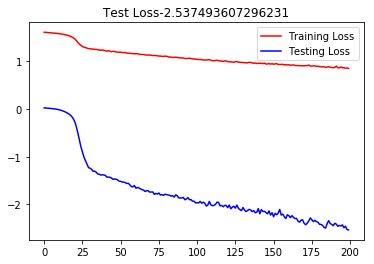

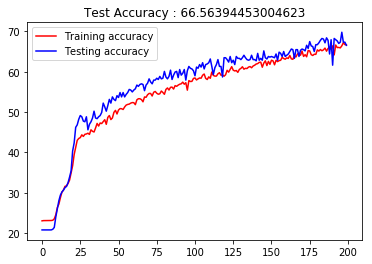

In [13]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', val_loss[-1])
print('Testing Accuracy:', test_accu[-1])
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(test_accu[-1]))
plt.legend()
plt.show()

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft

NameError: name 'model_ft' is not defined

In [ ]:
summary(model_ft,(3,32,32))